# Generación de rostros artificiales usando redes adversarias

## Contenido

- *dataset*: carpeta con el set de datos utilizado durante el entrenamiento. Contiene 3,755 imágenes a color de rostros humanos reales, cada una con un tamaño de 128x128.
- *ejemplos*: carpeta con 100 ejemplos de imágenes obtenidas tras el entrenamiento de la GAN.
- *utilidades.py*: funciones para la lectura del set de entrenamiento, la visualización de las imágenes obtenidas y la generación de imágenes con el modelo entrenado.
- *generacion_de_rostros.py*: implementación de la GAN para la generación de rostros artificiales

## Lecturas recomendadas

- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. In Advances in neural information processing systems (pp. 2672-2680).
- Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised representation learning with deep convolutional generative adversarial networks. arXiv preprint arXiv:1511.06434.

## Dependencias
matplotlib==2.0.0
numpy==1.15.4
Keras==2.2.4
imageio==2.5.0

In [1]:
import os
from imageio import imread, imwrite
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
dataset = "../Datasets/GAN_Rostros_Artificiales/dataset"
ejemplos = "../Datasets/GAN_Rostros_Artificiales/ejemplos"

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input
from keras.layers.core import Activation
from keras.optimizers import Adam

In [3]:
# Creación del set de entrenamiento
def cargar_datos():
	print('Creando set de entrenamiento...',end="",flush=True)
	filelist = os.listdir(dataset)

	n_imgs = len(filelist)
	x_train = np.zeros((n_imgs,128,128,3))

	for i, fname in enumerate(filelist):
		if fname != '.DS_Store':
			imagen = imread(os.path.join(dataset,fname))
			x_train[i,:] = (imagen - 127.5)/127.5
	print('¡Listo!')

	return x_train

In [4]:
# Visualizar imágenes del set de entrenamiento
def visualizar_imagen(nimagen,x_train):
	imagen = (x_train[nimagen,:]*127.5) + 127.5
	imagen = np.ndarray.astype(imagen, np.uint8)
	plt.imshow(imagen.reshape(128,128,3))
	plt.axis('off')
	plt.show()

In [5]:
# Visualización de algunas imagenes obtenidas con el generador
def graficar_imagenes_generadas(epoch, generador, ejemplos=16, dim=(4,4), figsize=(10,10)):
    ruido = np.random.normal(0,1,[ejemplos,100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(ejemplos,128,128,3)
    imagenes_generadas = imagenes_generadas*127.5 + 127.5
    plt.figure(figsize=figsize)
    for i in range(ejemplos):
        plt.subplot(dim[0],dim[1], i+1)
        plt.imshow(imagenes_generadas[i].astype('uint8'), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('GAN_imagen_generada_%d.png' %epoch)
    plt.close()

In [6]:
# Generar imágenes ejemplo
def generar_imagenes(generador,nimagenes):
	ruido = np.random.normal(0,1,[nimagenes,100])
	imagenes_generadas = generador.predict(ruido)
	imagenes_generadas.reshape(nimagenes,128,128,3)
	imagenes_generadas = imagenes_generadas*127.5 + 127.5
	imagenes_generadas.astype('uint8')
	for i in range(nimagenes):
		imwrite(os.path.join(ejemplos,'ejemplo_'+str(i)+'.png'),imagenes_generadas[i].reshape(128,128,3))

In [7]:
# Inicialización de parámetros
OPTIMIZADOR = Adam(lr=0.0002, beta_1=0.5)
TAM_ENTRADA = 100
ERROR = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
TAM_LOTE = 128 
N_ITS = 8000

In [8]:
# Crear set de entrenamiento y visualizar una imagen
x_train = cargar_datos()

Creando set de entrenamiento...¡Listo!


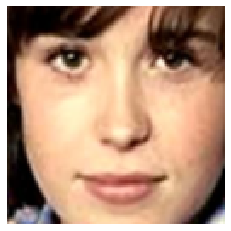

In [9]:
nimagen = np.random.randint(0,x_train.shape[0])
visualizar_imagen(nimagen,x_train)

In [9]:
# Generador
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(1024*4*4, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((4,4,1024)))
    #4x4x1024

    modelo.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2DTranspose(3, (5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(Activation('tanh'))
    #128x128x3

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

In [10]:
generador = crear_generador()
generador.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

In [11]:
# cargar los pesos del modelo por si ya está entrenado
generador.load_weights("generador.h5")

In [12]:
# Discriminador (el inverso del generador)
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(128,128,3),
        use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2D(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2D(1024, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #4x4x1024

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

In [13]:
discriminador = crear_discriminador()
discriminador.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4800      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204800    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       819200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 256)      

In [14]:
# GAN
def crear_GAN(generador, discriminador):
    modelo = Sequential()
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

In [15]:
gan = crear_GAN(generador, discriminador)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       19120576  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 17436864  
Total params: 36,557,440
Trainable params: 19,085,888
Non-trainable params: 17,471,552
_________________________________________________________________


In [16]:
# Entrenamiento
n_lotes = x_train.shape[0]/TAM_LOTE

for i in range(1200,N_ITS+1):
    print("Epoch " + str(i))

    # Crear un "batch" de imágenes falsas y otro con imágenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)

    idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
    batch_reales = x_train[idx]

    # Entrenar discriminador con imagener falsas y reales, y en cada
    # caso calcular el error
    discriminador.trainable = True

    dError_reales = discriminador.train_on_batch(batch_reales,
        np.ones(TAM_LOTE)*0.9)
    dError_falsas = discriminador.train_on_batch(batch_falsas,
        np.zeros(TAM_LOTE)*0.1)

    discriminador.trainable = False

    # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN
    # como si fuesen imagenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

    # Graficar ejemplo de imágenes generadas, cada 500 iteraciones
    if i==1 or i%500 == 0:
        graficar_imagenes_generadas(i,generador)
        generador.save('generador.h5')

Epoch 5458
Epoch 5459
Epoch 5460
Epoch 5461
Epoch 5462
Epoch 5463
Epoch 5464
Epoch 5465
Epoch 5466
Epoch 5467
Epoch 5468
Epoch 5469
Epoch 5470
Epoch 5471
Epoch 5472
Epoch 5473
Epoch 5474
Epoch 5475
Epoch 5476
Epoch 5477
Epoch 5478
Epoch 5479
Epoch 5480
Epoch 5481
Epoch 5482
Epoch 5483
Epoch 5484
Epoch 5485
Epoch 5486
Epoch 5487
Epoch 5488
Epoch 5489
Epoch 5490
Epoch 5491
Epoch 5492
Epoch 5493
Epoch 5494
Epoch 5495
Epoch 5496
Epoch 5497
Epoch 5498
Epoch 5499
Epoch 5500
Epoch 5501
Epoch 5502
Epoch 5503
Epoch 5504
Epoch 5505
Epoch 5506
Epoch 5507
Epoch 5508
Epoch 5509
Epoch 5510
Epoch 5511
Epoch 5512
Epoch 5513
Epoch 5514
Epoch 5515
Epoch 5516
Epoch 5517
Epoch 5518
Epoch 5519
Epoch 5520
Epoch 5521
Epoch 5522
Epoch 5523
Epoch 5524
Epoch 5525
Epoch 5526
Epoch 5527
Epoch 5528
Epoch 5529
Epoch 5530
Epoch 5531
Epoch 5532
Epoch 5533
Epoch 5534
Epoch 5535
Epoch 5536
Epoch 5537
Epoch 5538
Epoch 5539
Epoch 5540
Epoch 5541
Epoch 5542
Epoch 5543
Epoch 5544
Epoch 5545
Epoch 5546
Epoch 5547
Epoch 5548

KeyboardInterrupt: 

In [20]:
graficar_imagenes_generadas(5876,generador)

In [17]:
generador.save('generador.h5')

In [19]:
generar_imagenes(generador,3)

Lossy conversion from float32 to uint8. Range [0.0, 254.97557067871094]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 254.99139404296875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 254.9573516845703]. Convert image to uint8 prior to saving to suppress this warning.
